In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import src.utils.data_utils as data_utils

# Check if LaTeX is available, if not we don't import the plot_config module
latex_available = False
try:
    plt.rcParams['text.usetex'] = True
    plt.text(0, 0, "Test", fontsize=12)
    latex_available = True
    plt.close()
except Exception as e:
    print("LaTeX is not available. Error:", e)
finally:
    plt.rcParams['text.usetex'] = False

# Import the plot_config module if LaTeX is available
if latex_available:
    import src.utils.plot_config

%matplotlib inline

In [2]:
# Download the data files
datasets = [ 
    # ("https://zenodo.org/records/4650046/files/_raw_df_channels.tsv.gz?download=1", "channels.tsv.gz"), # 6.0 MB
    # ("https://zenodo.org/records/4650046/files/yt_metadata_en.jsonl.gz?download=1", "yt_metadata.jsonl.gz"), # 13.6 GB
]

data_utils.get_data(datasets)

In [3]:
# Open and read the file
df_video_counts = pd.read_json('data/video_counts.jsonl.gz', lines=True, compression='gzip')
df_video_counts.sample(3)

,channel_id,video_count
96376,UCEVrcIMWe6LwUdtV7jt9Mcw,2290
7591,UColu1Rhv3-04apNr3BpvJLg,718
52031,UCxAeHdLDAatFV_vt95MSO-g,9181


# Classification using keywords

## Chunk Processing

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

The following cell tests the `preprocess_collaborations` function (defined in data_utils.py).



**Comment on methodology:** 
- The detection of collaborations is based on the presence of specific keywords in the video title, by default the keywords are:`feat`, `ft`, `featuring`, `x`, `w/`, `ft.`.
- This approach is really simple and may not be accurate in all cases. We could have considered other keywords such as `with`, `and`, `&`, etc. but this would yield a greater number of false positives (this has been tested). 
- With this approach, we may have many false negatives, i.e. collaborations that are not detected.
- We also tested the detection of collaborations using a zero-shot model (see the cell at the end of this notebook). This approach revealed that the zero-shot model is not accurate enough to be used in this context (and it is also much slower).

</div>

In [4]:
# Load a chunk of data
data_file = 'data/yt_metadata.jsonl.gz'
test_data = pd.read_json(data_file, lines=True, compression="gzip", nrows=100_000)

# Preprocess the data
processed_df = data_utils.preprocess_collaborations(test_data)
processed_df.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date
8807,Music,Logan Paul - Hero ft. Zircon (Piano Cover ),DOWNLOAD FOR FREE MY 10 TIPS CHECKLIST TO HELP...,"piano,pianist,cover,live,musician,creative,tut...",4299,60.0,7.0,UCzWLloEwMWZYnUErRF5WWCg,2017-06-21 00:00:00
7851,Music,Post Malone - Goodbyes ft Young Thug (Piano Tu...,Piano Sheet Music: https://www.musicnotes.com/...,"piano,pianist,cover,live,musician,creative,tut...",66828,1004.0,33.0,UCzWLloEwMWZYnUErRF5WWCg,2019-07-04 00:00:00
7989,Music,Martin Garrix - No Sleep ft Bonn (Piano Tutorial),Piano Sheet Music: http://bit.ly/2CgTrmx\nDOWN...,"piano,pianist,cover,live,musician,creative,tut...",1944,53.0,1.0,UCzWLloEwMWZYnUErRF5WWCg,2019-03-12 00:00:00


## Process the whole dataset

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

The following cells process the whole dataset and saves the results to new files.

This should be done only once, as it may take a long time to run.

</div>

In [5]:
# Define the input and output paths
data_file = 'data/yt_metadata.jsonl.gz'
output_path = 'data/collaborations.jsonl.gz'
chunk_size = 100_000

In [6]:
# Process the collaboration data (this may take ~30 minutes) 
# data_utils.process_data(data_file, chunk_size, preprocess_collaborations, output_path)

In [7]:
# Process the number of videos per channel_id
# data_utils.process_video_counts(data_file, chunk_size, output_path='data/video_counts.jsonl.gz')

## Open the processed data

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

In the cells below, we open the processed data and display the first few rows. Then, we display the number of collaborations in each category.

In previous analysis, we found that the total number of Music videos is ~ 8.2 M and the total number of Entertainment videos is ~ 12.3 M, we can therefore compare the fraction of collaborations in each category. 
</div>

In [8]:
# Load the processed data and display the first few rows
df_collaborations = pd.read_json('data/collaborations.jsonl.gz', lines=True, compression='gzip')
df_collaborations.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date
243454,Music,NoYesMan feat. Phine - Why (DrumMasterz Radio ...,NoYesMan feat. Phine's new single Why (DrumMas...,"NoYesMan feat. Phine,Why,Handsup,Domega Record...",31,0,0,UCe0j_gCr3Fwx2QQ-Qlhvw3g,2019-08-19 00:00:00
484044,Music,Oonga & Barrio Lindo - Tu Me Llevas (ft. Ramon...,"From the digital compilation album ""Elements o...","top,millemon,world beats,ethno,tribal,song,exo...",12925,375,8,UCOzLLM-wTfbnz9cJAXSB08g,2019-03-03 00:00:00
851672,Music,Lee Marrow Feat. Charme - I Want Your Love,,,1355,26,0,UC2YYjbDpnz_OjmzZsaJbqug,2015-12-16 00:00:00


In [9]:
# Display the number of collaborations in each category
counts = df_collaborations.value_counts('categories')
print(f"Fraction of collaborations in the Music category: {100 * counts['Music'] / 8.2e6:.1f} %")
print(f"Fraction of collaborations in the Entertainment category: {100 * counts['Entertainment'] / 12.3e6:.1f} %")

Fraction of collaborations in the Music category: 8.6 %
Fraction of collaborations in the Entertainment category: 1.8 %


<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Comment:** with our collaboration detection technique, there are more collaborations in the Music category compared to the Entertainment category.

</div>

In [10]:
df_video_counts = pd.read_json('data/video_counts.jsonl.gz', lines=True, compression='gzip')
df_video_counts.sample(3)

,channel_id,video_count
69042,UCPikWj7oT-4OUrPUj7oyJ2Q,152
38503,UCbrEW5F3BhwOwP24kV2Wj3A,19
102547,UCBgMbdz-fBTNxKvUtmmI5aQ,404


## Are collaborations more prone to greater viewership and engagement? 

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We can start by studying the distribution of the number of views, likes, and dislikes for collaborations in each category.

We can then 
1. Compare the distributions for collaborations between the Music and Entertainment categories.
2. Compare the distributions for collaborations and non-collaborations in each category. 

Point 1. will help us understand if one category has the upper hand when it comes to collaborations. 

Point 2. will help us understand if collaborations are more successful than non-collaborations in each category.

</div>

In [11]:
# We start by creating a dataframe per category
df_music = df_collaborations[df_collaborations['categories'] == 'Music'].copy()
df_entertainment = df_collaborations[df_collaborations['categories'] == 'Entertainment'].copy()

In [12]:
df_music.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date
270476,Music,Natty Gong ft. Manna'C - Pié Dan Lo (Soul-Faya...,Subscribe to the channel Soul Faya Production ...,"soul,faya,natty,gong,manna,pie,dan,lo,reflip,d...",142945,1584,44,UCc4NMpUlZrP5C7yd0jp8EIw,2017-11-03 00:00:00
431396,Music,(FREE) Lil Tecca x Juice WRLD Type Beat 2019 -...,💰 Purchase This Beat | Instant Delivery (Untag...,"lil tecca type beat,free lil tecca type beat,l...",4838,199,0,UCScHkAuZPyUCH7Nz6XMmEQg,2019-06-28 00:00:00
310420,Music,"""uber2me"" Bryson Tiller Feat. Drake & Roy Wood...",Prod. River Beats\n\nLease here:\n\nhttps://ri...,"bryson,tiller,drake,views,from,the,six,with,me...",2926,41,2,UCa3qbPG86prcc51p8Tl8kTw,2016-06-06 00:00:00


In [13]:
df_entertainment.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date
434071,Entertainment,JASMINE SANDLAS feat GARRY SANDHU | ILLEGAL WE...,Beyonce of #Bollywood here and everyone has be...,"garry sandhu,jasmine sandlas,jasmine sandlas s...",3027,68,12,UCSSFXJTQhv680304l-VSmWg,2019-08-03 00:00:00
197513,Entertainment,V-LO The Maestro feat. Project Pat - Ready (Of...,The official audio of V-LO The Maestro feat. P...,"4sho Magazine,4shoMag,Joseph McFashion,4sho Ma...",674,14,2,UCgtvxGo5AWWZqOkMeS9_FdA,2019-08-31 00:00:00
510839,Entertainment,Protein Cheesecake w/Josie Mai,Big thanks to Josie for the video. If you have...,"protein recipe,healthy dessert,cheesecake,heal...",26829,938,67,UCNfwT9xv00lNZ7P6J6YhjrQ,2015-03-08 00:00:00


### Distribution of views, likes, and dislikes for Music and Entertainment collaborations

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We start by plotting the distribution of views, likes, and dislikes for the Music and Entertainment categories separately.

(Uncomment the cell below to run it, the results are directly compared below).

</div>

In [14]:
# Distributions for the Music category
# data_utils.plot_category_distribution(df_data=df_music,
#                                       columns=["view_count", "like_count", "dislike_count"],
#                                       category="Music",
#                                       x_logs=[True, True, True],
#                                       y_logs=[False, False, True],
#                                       kind="hist",
#                                       print_summary=True)

In [15]:
# Distributions for the Entertainment category
# data_utils.plot_category_distribution(df_data=df_entertainment,
#                                       columns=["view_count", "like_count", "dislike_count"],
#                                       category="Entertainment",
#                                       x_logs=[True, True, True],
#                                       y_logs=[False, False, True],
#                                       kind="hist",
#                                       print_summary=True)

### Comparison of views, likes, and dislikes between Music and Entertainment collaborations

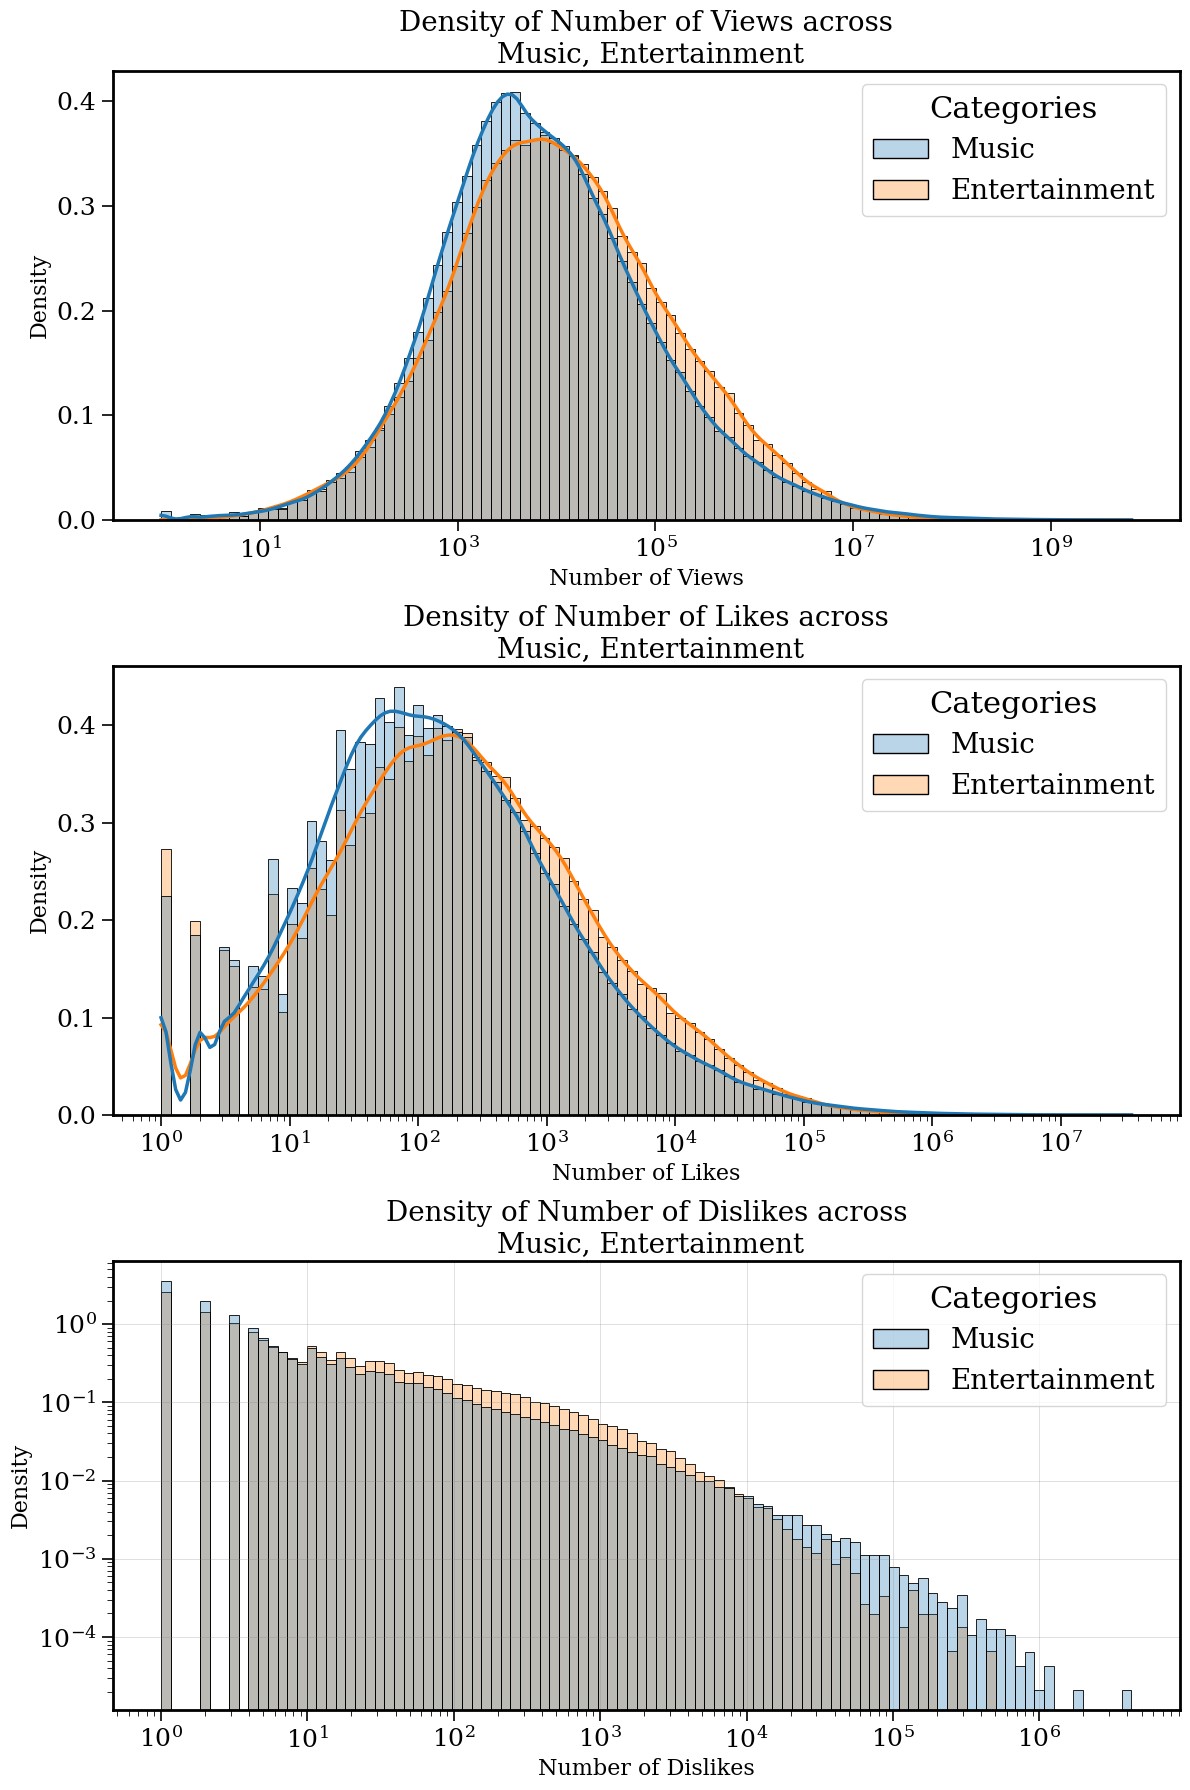

In [16]:
categories = ["Music", "Entertainment"]
data_utils.compare_distribution_across_categories(df_collaborations,
                                                  columns=["view_count", "like_count", "dislike_count"],
                                                  categories=categories,
                                                  hue="categories",
                                                  x_logs=[True, True, True],
                                                  y_logs=[False, False, True],
                                                  kind="hist",
                                                  marker_only=False, 
                                                  density=True)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments:**

- The distribution of views for the Music category seems to be slightly skewed to the left compared to the Entertainment category. 

- A similar observation can be made for the distribution of likes. 

- The distribution of dislikes seems almost power-law distributed for the Music category. The Entertainment distribution is a bit more "rounded". 

In each case, since we log-transformed the x-axis, we can look at the geometric mean to compare the two categories.

</div>

In [17]:
# Compute both geometric and arithmetic means for each category
columns = ["view_count", "like_count", "dislike_count"]

music_gmeans = {col: data_utils.geometric_mean(df_music[col]) for col in columns}
entertainment_gmeans = {col: data_utils.geometric_mean(df_entertainment[col]) for col in columns}

music_means = {col: df_music[col].mean() for col in columns}
entertainment_means = {col: df_entertainment[col].mean() for col in columns}

# Display the comparison in a unified table
print("Comparison of geometric and arithmetic Means for Music and Entertainment Categories:\n")
print(f"{'Metric':<20} {'Music (Geometric)':<20} {'Entertainment (Geometric)':<30} {'Music (Arithmetic)':<20} {'Entertainment (Arithmetic)':<20}")
print("-" * 120)

for col in columns:
    music_geo = music_gmeans[col]
    music_arith = music_means[col]
    ent_geo = entertainment_gmeans[col]
    ent_arith = entertainment_means[col]
    print(f"{col:<20} {music_geo:<20.2f} {ent_geo:<30.2f} {music_arith:<20.2f} {ent_arith:<20.2f}")

Comparison of geometric and arithmetic Means for Music and Entertainment Categories:

Metric               Music (Geometric)    Entertainment (Geometric)      Music (Arithmetic)   Entertainment (Arithmetic)
------------------------------------------------------------------------------------------------------------------------
view_count           7716.97              10885.06                       681441.02            311771.52           
like_count           145.24               194.23                         5114.49              3640.42             
dislike_count        6.58                 10.81                          228.10               166.95              


<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments**

- When looking at the geometric means, the Entertainment category seems to have the upper hand in terms of views and likes (as can be seen from the distributions).
- Interestingly, when looking at the arithmetic means (that might be ill-defined), the Music category seems to have higher values for views and likes. This is probably due to the presence of **stronger outliers in the Music category**. 

</div>

## Which category exhibits more collaborations? 

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

For each channel, we will compute a "collaboration ratio" defined as 
$$
\text{collaboration ratio} = \frac{\text{number of collaboration videos}}{\text{total number of videos}}. 
$$

This will allow us to group the collaborations by category and compare the distribution of the collaboration ratio between the Music and Entertainment categories. 

**Method**: 
1. Add a new column to the collaborations data that counts the number of collaborations for each channel
2. Add the total number of videos for each channel to the collaborations data
3. Merge the collaborations data with the channels data to get the channel names and other information (that will be useful for other analysis)
4. Compute the collaboration ratio for each channel and category
5. Compare the distribution of the collaboration ratio between the Music and Entertainment categories

</div>


In [18]:
# 1. 
# Add a new column to the collaborations data that counts the number of collaborations for each channel
df_collaborations['collaborations_count'] = df_collaborations.groupby('channel_id')['channel_id'].transform('count')

print(f"Number of unique channels in the collaborations data: {df_collaborations['channel_id'].nunique()}")
df_collaborations.sample(3)

Number of unique channels in the collaborations data: 36966


,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date,collaborations_count
56008,Music,Andy Grammer - Give Love Feat. LunchMoney Lewi...,Get the new single now!\nhttp://smarturl.it/Gi...,"andy grammer,give love,lunchmoney lewis,honey ...",1470769,7117,193,UCozJsFq5BE_nrVGr567EwOQ,2017-08-23 00:00:00,6
825091,Music,"(FREE) 6lack x PARTYNEXTDOOR Type Beat - ""Mind...",💰 Purchase Untagged | (Instant Delivery) - htt...,"type beat,type beat 2018,free type beat,instru...",4880,177,3,UC4jljAJ1PBQxFxSx6f0vFMw,2019-02-16 00:00:00,194
671493,Music,Harlem Spartans x 67 Dimzy x Mischief (Trap/Dr...,[UK DRILL]\n\nHarlem Spartans x 67 Dimzy x Mis...,"Jamma Beats,Harlem spartans,Harlems Spartans t...",15214,268,2,UCDUBbmsjoIFMCPWQ53UHEbw,2016-12-04 00:00:00,92


In [19]:
# 2. 
# Merge the collaborations data with the video counts data
df_collaborations = pd.merge(df_collaborations, df_video_counts, on='channel_id', how='left')
df_collaborations.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date,collaborations_count,video_count
422841,Music,"Classixx - ""Just Let Go"" (featuring How To Dre...",Faraway Reach' out now: https://smarturl.it/Fa...,"classixx,just let go,how to dress well",762,9,0,UCTN2ISSUlha5r7ysqjh47bg,2016-10-17 00:00:00,45,354
414983,Music,Violence (feat. Jon Bellion),Provided to YouTube by Rebel Rock/Grand Hustle...,"B.o.B,Jon Bellion,Psycadelik Thoughtz,Violence...",31843,451,30,UCU1JusGzZe0Msn79JB3g46w,2017-03-16 00:00:00,59,341
820468,Music,Burger Man x Foe Gang Billo x Glory Svntvna - ...,"In this video, watch random people around Holl...","ismyshittight,street reactions,reactions,imst,...",922,41,1,UC4zv-nRwCekqub6hsfGfnWQ,2019-04-22 00:00:00,35,233


In [20]:
# 3. 
# Open the channels data, filter the Music and Entertainment categories, and drop the join_date column
df_channels = pd.read_csv('data/channels.tsv.gz', sep='\t', compression='gzip')
df_channels = df_channels[df_channels['category_cc'].isin(['Music', 'Entertainment'])]
df_channels = df_channels.drop(columns=['join_date', 'category_cc', 'videos_cc'], axis=1)
df_channels = df_channels.rename(columns={'channel': 'channel_id'})

print(f"Number of unique channels in the Entertainment and Music categories: {df_channels.shape[0]}")

# Merge the channel names to the collaborations data
df = pd.merge(df_collaborations, df_channels, on='channel_id', how='left')

# Create a new column that calculates the ratio of collaborations to the total number of videos
df['colab_ratio'] = df['collaborations_count'] / df['video_count']

# Reorder the columns
new_order = ['name_cc', 'title', 'view_count', 'like_count', 'dislike_count', 'description', 'tags', 'upload_date', 'subscribers_cc',
             'video_count', 'collaborations_count', 'colab_ratio', 'channel_id', 'categories']

df = df[new_order].copy()
df.sample(3)

Number of unique channels in the Entertainment and Music categories: 55513


,name_cc,title,view_count,like_count,dislike_count,description,tags,upload_date,subscribers_cc,video_count,collaborations_count,colab_ratio,channel_id,categories
60360,houseofrapmx,Doble cara - Dazzicko ft RVM,274,6,1,SUSCRIBETE\n\nMANDANOS TUS CANCIONES A LA PAGI...,"rap,rap latino,rap michocan,rap zitacuaro,hip ...",2016-08-03 00:00:00,14200.0,85,37,0.435294,UColy6XwtFfuTDeqr9jF6iCA,Music
654888,The X Factor UK,The Result - The Final - The X Factor UK 2012,2176443,5464,968,Watch judges' comments at http://itv.com/XFact...,"the x factor,X factor uk,x factor 2012,x facto...",2012-12-08 00:00:00,8050000.0,4450,4059,0.912135,UCEY1ejsweY4DgMwOVJeEaBA,Entertainment
26413,Trap and Bass,Zeds Dead x NGHTMRE - Frontlines ft. GG Magree...,18426,556,38,Download: http://smarturl.it/ZD_FrontlinesRmx\...,"NGHTMRE & Zeds Dead - Frontlines (Wuki Remix),...",2017-03-20 00:00:00,833000.0,1339,398,0.297237,UCqmhfPcgiaRVWUy9F_HeV5g,Entertainment


In [21]:
# 4. Collect the collaboration ratio for each channel and category
df_colab_ratio = df.groupby(['channel_id', 'categories'])['colab_ratio'].mean().reset_index()
df_colab_ratio.sample(3)

,channel_id,categories,colab_ratio
16595,UCPB1AAcJpsUmmaE-SGciUIw,Entertainment,0.013514
21041,UCWELz_AhphofsCaOT6jJu4g,Music,0.056604
21277,UCWcTW3kArrXO_kE6pHJISKQ,Entertainment,0.065089


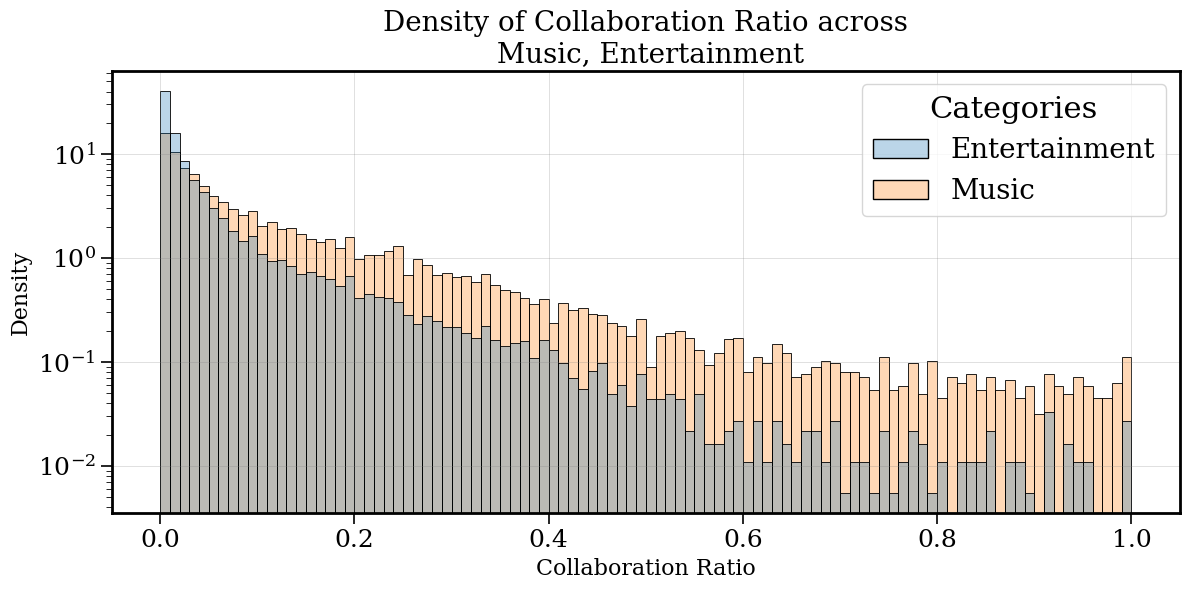

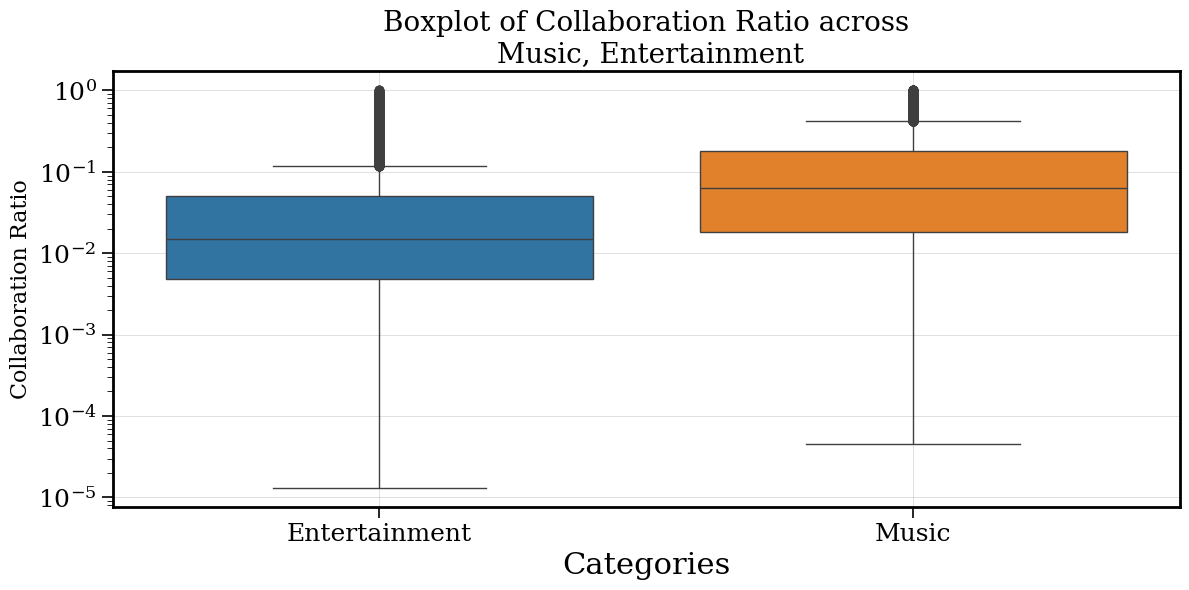

In [22]:
# 5. Comparison of the collaboration ratio between the Music and Entertainment categories
data_utils.compare_distribution_across_categories(df_colab_ratio,
                                                  columns=["colab_ratio"],
                                                  categories=["Music", "Entertainment"],
                                                  hue="categories",
                                                  x_logs=[False],
                                                  y_logs=[True],
                                                  kind="hist",
                                                  marker_only=False,
                                                  density=True)

data_utils.compare_distribution_across_categories(df_colab_ratio,
                                                  columns=["colab_ratio"],
                                                  categories=["Music", "Entertainment"],
                                                  hue="categories",
                                                  x_logs=[False],
                                                  y_logs=[True],
                                                  kind="boxplot")

In [23]:
combined_desc = pd.DataFrame({
    'Music': df_colab_ratio[df_colab_ratio['categories'] == 'Music']['colab_ratio'].describe(),
    'Entertainment': df_colab_ratio[df_colab_ratio['categories'] == 'Entertainment']['colab_ratio'].describe()
})

combined_desc

,Music,Entertainment
count,22296.000000,18368.000000
mean,0.130323,0.051594
std,0.169132,0.096726
min,0.000045,0.000013
25%,0.018405,0.004796
50%,0.062500,0.015152
75%,0.178701,0.049986
max,1.000000,1.000000


<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments:** 

From the histograms: 
- In both categories, the collaboration ratio seems to be decreasing, i.e. there are more channels with a low collaboration ratio than with a high collaboration ratio.
- The collaboration ratio for the Entertainment category is decaying faster than for the Music category. 

From the violin plots:
- The median collaboration ratio is higher for the Music category, it is greater than the 75th percentile of the Entertainment category.

From the summary statistics:
- The mean and median collaboration ratio are higher for the Music category.
- As seen in the violinplot, the median of the Music category is greater than the 75th percentile of the Entertainment category.

**Conclusion:** Overall, the creators in the Music category seem to have a higher collaboration ratio than the creators in the Entertainment category.
</div>

---

<div style="background-color: #FFC0CB; border-left:3px solid red; padding: 10px; border-radius: 5px;">

Autres idées:

- Possible de faire un test statitstique pour vérifier si la différence des distributions est significative?

</div>

## Evolution of collaborations over time: is there an obvious collaboration strategy? 

<div style="background-color: #FFC0CB; border-left:3px solid red; padding: 10px; border-radius: 5px;">

- Regarder l'évolution du nombre de collaborations au fil du temps grâce à la colonne `upload_date`

</div>

## Is there a correlation between the number of collaborations and a channel success? 

<div style="background-color: #FFC0CB; border-left:3px solid red; padding: 10px; border-radius: 5px;">

- Corrélation entre chaîne plus connue et les collaborations. Est-ce qu'une chaîne qui fait souvent des collaborations également plus généralement connues?

</div>

## Do creators that make both music and entertainment content have more collaborations?



# Classification using a Zero-Shot Model

In [24]:
# from transformers import pipeline
# 
# def is_significant(collab_score, non_collab_score, threshold=0.1):
#     """
#     Check if the difference between two scores is significant.
# 
#     Args:
#         collab_score (float): Score for the collaboration label.
#         non_collab_score (float): Score for the non-collaboration label.
#         threshold (float): Minimum difference to consider the scores significant.
# 
#     Returns:
#         bool: True if the scores are significant, False otherwise.
#     """
#     return abs(collab_score - non_collab_score) > threshold
# 
# 
# MODEL_PATH = 'src/models/zero-shot-classification'
# 
# # Load the zero-shot classification model
# classifier = pipeline("src/models/zero-shot-classification", model="facebook/bart-large-mnli")
# 
# # Save the model to disk
# model_path = "src/models/zero-shot-classification"
# classifier.save_pretrained(model_path)
# 
# # Labels for the zero-shot classification model
# music_collab_labels = ['multiple artists']
# music_non_collab_labels = ['a single artist']
# music_labels = music_collab_labels + music_non_collab_labels
# 
# # Hypothesis template for the zero-shot classification model
# music_hypothesis_template = "This music is with {}."
# 
# texts = ["Radiohead live at Glastonbury 2003",
#          "The Beatles - Hey Jude", 
#          "Best of Debussy",
#          "HAYATO SUMINO – third round (18th Chopin Competition, Warsaw)",
#          "LL COOL J - Murdergram Deux ft. Eminem", 
#          "Eminem - Love The Way You Lie ft. Rihanna"
#          ]
# 
# for text in texts:
#     result = classifier(
#         text,
#         candidate_labels=music_labels,
#         hypothesis_template=music_hypothesis_template,
#         multi_label=False,
#     )
# 
#     # Extract scores for collaboration and non-collaboration labels
#     collab_scores = np.array([score for label, score in zip(result['labels'], result['scores']) if label in music_collab_labels])
#     non_collab_scores = np.array([score for label, score in zip(result['labels'], result['scores']) if label in music_non_collab_labels])
# 
#     total_collab_score = collab_scores.sum()
#     total_non_collab_score = non_collab_scores.sum()
# 
#     # Check if the scores are significant
#     if is_significant(total_collab_score, total_non_collab_score, threshold=0.5):
#         # Décider de la catégorie basée sur le score maximal
#         if total_collab_score > total_non_collab_score:
#             prediction = "Collaborative"
#         else:
#             prediction = "Non-Collaborative"
#     else:
#         continue
# 
#     print(f"Text: {text}. "
#           f"\n    - Predicted category: {prediction}, "
#           f"\n    - collab_score: {total_collab_score}, "
#           f"\n    - non_collab_score: {total_non_collab_score}")